## 1. Introducción <a name="introduccion"></a>

### 1.1 Contexto del Proyecto

Este proyecto investiga la capacidad predictiva de redes neuronales LSTM para el precio del oro (XAU/USD), integrando análisis de sentimientos de noticias financieras del Wall Street Journal. El objetivo es determinar si existe causalidad entre eventos noticiosos y movimientos anómalos en los precios.

### 1.2 Objetivos de este Notebook

En este primer notebook estableceremos las bases del análisis:

- ✅ Configurar el entorno computacional con todas las dependencias necesarias
- ✅ Cargar y validar los datos de precios del oro (2016-2025)
- ✅ Cargar y validar los datos de noticias del WSJ
- ✅ Realizar limpieza básica y validación de calidad
- ✅ Exportar datasets limpios para análisis posteriores

### 1.3 Estructura del Proyecto

```
unificacion/
├── notebooks/
│   ├── 01_Introduccion_y_Carga_de_Datos.ipynb       ← Estamos aquí
│   ├── 02_Analisis_Exploratorio_Precios.ipynb
│   ├── 03_Analisis_Exploratorio_Noticias.ipynb
│   ├── 04_Deteccion_Anomalias.ipynb
│   ├── 05_Analisis_Sentimientos.ipynb
│   ├── 06_Correlacion_y_Causalidad.ipynb
│   ├── 07_Modelo_LSTM_Unificado.ipynb
│   └── 08_Resultados_y_Conclusiones.ipynb
├── scripts/
├── datos_procesados/
├── figuras/
└── informes/
```

## 2. Configuración del Entorno <a name="configuracion"></a>

### 2.1 Importación de Bibliotecas

In [46]:
# Manipulación de datos
import pandas as pd
import numpy as np

# Visualización
import matplotlib.pyplot as plt
import seaborn as sns

# Utilidades
import os
import sys
from pathlib import Path
from datetime import datetime, timedelta
import warnings

# Configuración de visualización
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (14, 6)
plt.rcParams['font.size'] = 11

# Suprimir warnings no críticos
warnings.filterwarnings('ignore')

# Configuración de pandas
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)
pd.set_option('display.precision', 4)

print("✓ Bibliotecas importadas correctamente")
print(f"✓ Versión de Pandas: {pd.__version__}")
print(f"✓ Versión de NumPy: {np.__version__}")

✓ Bibliotecas importadas correctamente
✓ Versión de Pandas: 2.3.3
✓ Versión de NumPy: 2.3.5


### 2.2 Definición de Rutas del Proyecto

In [47]:
# Ruta base del proyecto (ajustar según ubicación)
BASE_DIR = Path('/home/els4nchez/Videos/TECH')
UNIFICACION_DIR = BASE_DIR / 'unificacion'

# Rutas de datos originales
DATA_RAW_PRECIOS = BASE_DIR / 'datos_horas' / 'XAU_USD_2016-2025_01-12_1h_bars.csv'
DATA_RAW_NOTICIAS = BASE_DIR / 'articulos_filtrados_ordenados.csv'
DATA_NOTICIAS_COMPLETO = BASE_DIR / 'articulos_con_fechas_final.csv'

# Rutas de salida
DATA_PROCESADO_DIR = UNIFICACION_DIR / 'datos_procesados'
FIGURAS_DIR = UNIFICACION_DIR / 'figuras'

# Crear directorios si no existen
DATA_PROCESADO_DIR.mkdir(parents=True, exist_ok=True)
FIGURAS_DIR.mkdir(parents=True, exist_ok=True)

print("✓ Rutas del proyecto configuradas:")
print(f"  - Base: {BASE_DIR}")
print(f"  - Datos procesados: {DATA_PROCESADO_DIR}")
print(f"  - Figuras: {FIGURAS_DIR}")

# Verificar existencia de archivos de datos
print("\n✓ Verificación de archivos de entrada:")
for nombre, ruta in [
    ("Precios del oro", DATA_RAW_PRECIOS),
    ("Noticias filtradas", DATA_RAW_NOTICIAS),
    ("Noticias completas", DATA_NOTICIAS_COMPLETO)
]:
    existe = "✅ Encontrado" if ruta.exists() else "❌ NO ENCONTRADO"
    print(f"  - {nombre}: {existe}")
    if ruta.exists():
        tamaño = ruta.stat().st_size / (1024 * 1024)  # MB
        print(f"    Tamaño: {tamaño:.2f} MB")

✓ Rutas del proyecto configuradas:
  - Base: /home/els4nchez/Videos/TECH
  - Datos procesados: /home/els4nchez/Videos/TECH/unificacion/datos_procesados
  - Figuras: /home/els4nchez/Videos/TECH/unificacion/figuras

✓ Verificación de archivos de entrada:
  - Precios del oro: ✅ Encontrado
    Tamaño: 3.96 MB
  - Noticias filtradas: ✅ Encontrado
    Tamaño: 44.55 MB
  - Noticias completas: ✅ Encontrado
    Tamaño: 0.01 MB


## 3. Carga de Datos de Precios del Oro <a name="precios"></a>

### 3.1 Descripción de la Fuente de Datos

**Fuente:** Dukascopy Bank SA - Historical Data API  
**Activo:** XAU/USD (Oro vs Dólar Estadounidense)  
**Período:** 03 enero 2016 - 12 enero 2025  
**Frecuencia original:** Horaria (1h)  
**Observaciones esperadas:** ~54,000 barras horarias

### 3.2 Carga Inicial

In [48]:
# Cargar datos de precios
print("Cargando datos de precios del oro...")
df_precios_raw = pd.read_csv(DATA_RAW_PRECIOS)

print(f"\n✓ Datos cargados exitosamente")
print(f"  - Registros: {len(df_precios_raw):,}")
print(f"  - Columnas: {list(df_precios_raw.columns)}")
print(f"  - Memoria utilizada: {df_precios_raw.memory_usage(deep=True).sum() / 1024**2:.2f} MB")

# Mostrar primeras filas
print("\n📊 Primeras 5 filas:")
df_precios_raw.head()

Cargando datos de precios del oro...

✓ Datos cargados exitosamente
  - Registros: 54,116
  - Columnas: ['UTC', 'Open', 'High', 'Low', 'Close', 'Volume']
  - Memoria utilizada: 5.78 MB

📊 Primeras 5 filas:


,UTC,Open,High,Low,Close,Volume
0,03.01.2016 23:00:00 UTC,1062.341,1066.321,1061.729,1063.059,1.6114
1,04.01.2016 00:00:00 UTC,1063.059,1064.740,1062.729,1064.459,2.7790
2,04.01.2016 07:00:00 UTC,1069.809,1073.052,1068.518,1071.321,3.4554
3,04.01.2016 05:00:00 UTC,1065.358,1068.949,1065.049,1068.659,3.9656
4,04.01.2016 06:00:00 UTC,1068.660,1070.119,1067.909,1069.801,2.4066


### 3.3 Limpieza y Procesamiento de Datos de Precios

In [49]:
# Crear copia para procesamiento
df_precios = df_precios_raw.copy()

# PASO 1: Limpieza de columna UTC
print("PASO 1: Limpiando formato de timestamp...")
df_precios['UTC'] = df_precios['UTC'].str.replace(' UTC', '', regex=False)

# PASO 2: Conversión a datetime
print("PASO 2: Convirtiendo a formato datetime...")
df_precios['UTC'] = pd.to_datetime(df_precios['UTC'], format='%d.%m.%Y %H:%M:%S')

# PASO 3: Establecer índice temporal
print("PASO 3: Estableciendo índice temporal...")
df_precios = df_precios.set_index('UTC')
df_precios = df_precios.sort_index()

# PASO 4: Verificar información básica
print("\n✓ Limpieza completada")
print(f"  - Primer registro: {df_precios.index.min()}")
print(f"  - Último registro: {df_precios.index.max()}")
print(f"  - Duración: {(df_precios.index.max() - df_precios.index.min()).days} días")

# Información del DataFrame procesado
print("\n📊 Información del DataFrame:")
df_precios.info()

PASO 1: Limpiando formato de timestamp...
PASO 2: Convirtiendo a formato datetime...
PASO 3: Estableciendo índice temporal...

✓ Limpieza completada
  - Primer registro: 2016-01-03 23:00:00
  - Último registro: 2025-11-24 02:00:00
  - Duración: 3612 días

📊 Información del DataFrame:
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 54116 entries, 2016-01-03 23:00:00 to 2025-11-24 02:00:00
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Open    54116 non-null  float64
 1   High    54116 non-null  float64
 2   Low     54116 non-null  float64
 3   Close   54116 non-null  float64
 4   Volume  54116 non-null  float64
dtypes: float64(5)
memory usage: 2.5 MB


### 3.4 Agregación a Frecuencia Diaria

**Justificación:** Aunque los datos originales son horarios, el objetivo del proyecto requiere resolución **diaria** para:
- Alinear con frecuencia de publicación de noticias
- Reducir ruido intradiario
- Facilitar análisis de causalidad con eventos noticiosos

**Método de agregación:**
- Open: Primer precio del día
- High: Precio máximo del día  
- Low: Precio mínimo del día
- Close: Último precio del día
- Volume: Suma de volumen del día

In [50]:
print("Agregando datos a frecuencia diaria...")

df_precios_diario = df_precios.resample('D').agg({
    'Open': 'first',
    'High': 'max',
    'Low': 'min',
    'Close': 'last',
    'Volume': 'sum'
})

# Verificar días con datos faltantes
dias_faltantes = df_precios_diario['Close'].isna().sum()
print(f"\n✓ Agregación completada")
print(f"  - Días totales en rango: {len(df_precios_diario)}")
print(f"  - Días con datos: {df_precios_diario['Close'].notna().sum()}")
print(f"  - Días sin datos: {dias_faltantes}")
print(f"  - Porcentaje de completitud: {(1 - dias_faltantes/len(df_precios_diario))*100:.2f}%")

# Tratamiento de valores faltantes con forward fill
if dias_faltantes > 0:
    print(f"\nAplicando forward fill a {dias_faltantes} días faltantes...")
    df_precios_diario[['Open','High','Low','Close']] = \
        df_precios_diario[['Open','High','Low','Close']].ffill()
    
    # Verificar
    print(f"✓ Valores faltantes después de forward fill: {df_precios_diario['Close'].isna().sum()}")

# Mostrar estadísticas
print("\n📊 Primeros 10 días:")
df_precios_diario.head(10)

Agregando datos a frecuencia diaria...

✓ Agregación completada
  - Días totales en rango: 3614
  - Días con datos: 2844
  - Días sin datos: 770
  - Porcentaje de completitud: 78.69%

Aplicando forward fill a 770 días faltantes...
✓ Valores faltantes después de forward fill: 0

📊 Primeros 10 días:


,Open,High,Low,Close,Volume
UTC,,,,,
2016-01-03,1062.341,1066.321,1061.729,1063.059,1.6114
2016-01-04,1063.059,1083.488,1062.239,1072.979,76.5687
2016-01-05,1072.990,1082.048,1072.629,1077.632,72.4396
2016-01-06,1077.632,1095.180,1074.928,1092.559,77.5568
2016-01-07,1092.559,1110.080,1091.350,1109.210,94.9987
2016-01-08,1109.199,1112.949,1092.229,1104.031,89.0362
2016-01-09,1109.199,1112.949,1092.229,1104.031,0.0000
2016-01-10,1103.751,1108.151,1103.531,1106.622,0.5964
2016-01-11,1106.622,1108.401,1093.439,1095.690,90.4745


### 3.5 Estadísticas Descriptivas Básicas

In [51]:
# Calcular estadísticas descriptivas
print("📊 ESTADÍSTICAS DESCRIPTIVAS - PRECIOS DEL ORO (DIARIOS)")
print("="*70)

stats = df_precios_diario.describe().T
stats['rango'] = stats['max'] - stats['min']
stats['cv'] = (stats['std'] / stats['mean']) * 100  # Coeficiente de variación

print(stats.round(2))

# Identificar extremos
print("\n📈 VALORES EXTREMOS:")
print(f"  - Precio mínimo: ${df_precios_diario['Low'].min():.2f} en {df_precios_diario['Low'].idxmin().date()}")
print(f"  - Precio máximo: ${df_precios_diario['High'].max():.2f} en {df_precios_diario['High'].idxmax().date()}")
print(f"  - Rango total: ${df_precios_diario['High'].max() - df_precios_diario['Low'].min():.2f}")
print(f"  - Variación porcentual total: {((df_precios_diario['High'].max() / df_precios_diario['Low'].min()) - 1) * 100:.2f}%")

📊 ESTADÍSTICAS DESCRIPTIVAS - PRECIOS DEL ORO (DIARIOS)
         count     mean     std      min      25%      50%      75%      max  \
Open    3614.0  1805.34  620.21  1062.34  1295.60  1748.75  1956.75  4365.20   
High    3614.0  1816.84  626.39  1066.32  1302.97  1764.13  1966.22  4381.30   
Low     3614.0  1793.89  614.51  1061.73  1290.78  1744.72  1942.13  4233.30   
Close   3614.0  1806.03  621.50  1063.06  1297.35  1753.49  1956.94  4365.22   
Volume  3614.0    36.35   33.36     0.00     1.07    35.11    58.53   214.10   

          rango     cv  
Open    3302.86  34.35  
High    3314.98  34.48  
Low     3171.57  34.26  
Close   3302.17  34.41  
Volume   214.10  91.77  

📈 VALORES EXTREMOS:
  - Precio mínimo: $1061.73 en 2016-01-03
  - Precio máximo: $4381.30 en 2025-10-20
  - Rango total: $3319.57
  - Variación porcentual total: 312.66%


### 3.6 Visualización Preliminar de Precios

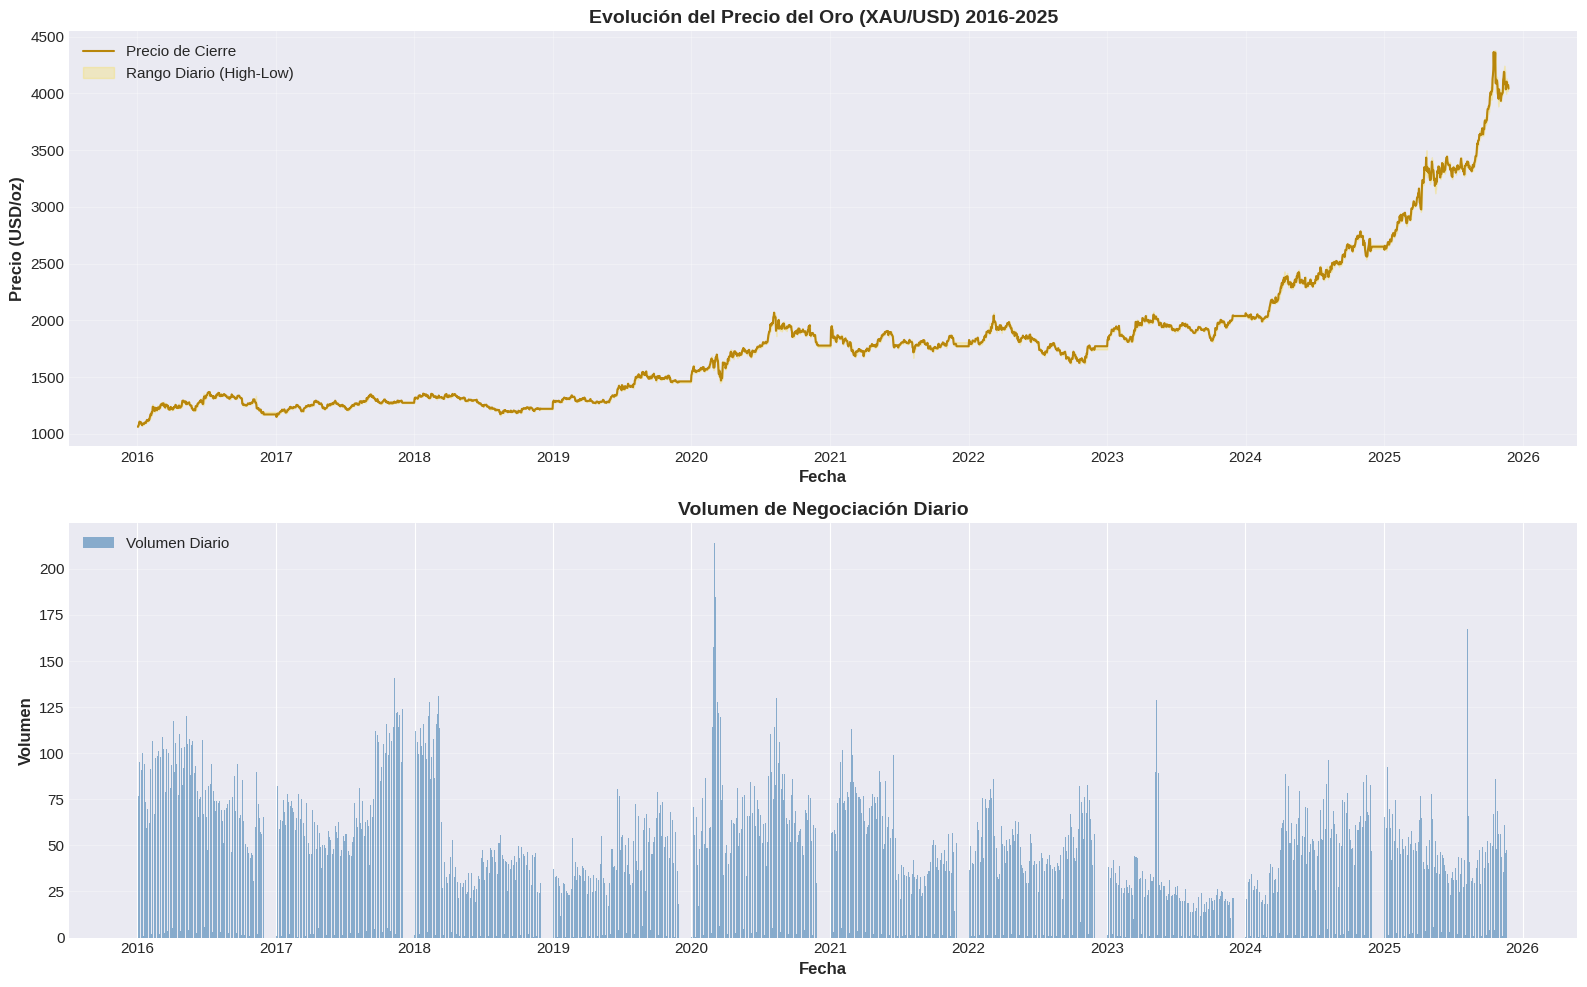

✓ Gráfico guardado en: /home/els4nchez/Videos/TECH/unificacion/figuras/01_serie_temporal_oro.png


In [52]:
# Crear figura con 2 subplots
fig, axes = plt.subplots(2, 1, figsize=(16, 10))

# Subplot 1: Serie temporal de precio de cierre
axes[0].plot(df_precios_diario.index, df_precios_diario['Close'], 
             linewidth=1.5, color='darkgoldenrod', label='Precio de Cierre')
axes[0].fill_between(df_precios_diario.index, 
                      df_precios_diario['Low'], 
                      df_precios_diario['High'],
                      alpha=0.2, color='gold', label='Rango Diario (High-Low)')
axes[0].set_xlabel('Fecha', fontsize=12, fontweight='bold')
axes[0].set_ylabel('Precio (USD/oz)', fontsize=12, fontweight='bold')
axes[0].set_title('Evolución del Precio del Oro (XAU/USD) 2016-2025', 
                  fontsize=14, fontweight='bold')
axes[0].legend(loc='upper left')
axes[0].grid(True, alpha=0.3)

# Subplot 2: Volumen
axes[1].bar(df_precios_diario.index, df_precios_diario['Volume'], 
            width=1, color='steelblue', alpha=0.6, label='Volumen Diario')
axes[1].set_xlabel('Fecha', fontsize=12, fontweight='bold')
axes[1].set_ylabel('Volumen', fontsize=12, fontweight='bold')
axes[1].set_title('Volumen de Negociación Diario', fontsize=14, fontweight='bold')
axes[1].legend(loc='upper left')
axes[1].grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.savefig(FIGURAS_DIR / '01_serie_temporal_oro.png', dpi=300, bbox_inches='tight')
plt.show()

print("✓ Gráfico guardado en:", FIGURAS_DIR / '01_serie_temporal_oro.png')

## 4. Carga de Datos de Noticias <a name="noticias"></a>

### 4.1 Descripción de la Fuente de Datos

**Fuente:** Wall Street Journal (WSJ)  
**Método de extracción:** Web scraping  
**Período:** 01 enero 2016 - diciembre 2025  
**Artículos totales:** ~189,000  
**Artículos relevantes al oro:** ~5,400

### 4.2 Carga Inicial

In [53]:
# Cargar datos de noticias
print("Cargando datos de noticias del Wall Street Journal...")
df_noticias_raw = pd.read_csv(DATA_RAW_NOTICIAS)

print(f"\n✓ Datos cargados exitosamente")
print(f"  - Artículos: {len(df_noticias_raw):,}")
print(f"  - Columnas: {list(df_noticias_raw.columns)}")
print(f"  - Memoria utilizada: {df_noticias_raw.memory_usage(deep=True).sum() / 1024**2:.2f} MB")

# Mostrar primeras filas
print("\n📰 Primeras 5 noticias:")
df_noticias_raw.head()

Cargando datos de noticias del Wall Street Journal...

✓ Datos cargados exitosamente
  - Artículos: 284,398
  - Columnas: ['titulo', 'url', 'fecha']
  - Memoria utilizada: 89.46 MB

📰 Primeras 5 noticias:


,titulo,url,fecha
0,"Ten Years After Blowup, Amaranth Investors Wai...",http://www.wsj.com/articles/ten-years-after-bl...,2016-01-01
1,Taliban Militants Bomb Restaurant in Kabul,http://www.wsj.com/articles/taliban-militants-...,2016-01-01
2,The NHL Scoring Title Remains Elusive for U.S....,http://www.wsj.com/articles/the-nhl-scoring-ti...,2016-01-01
3,What’s at Stake in NFL Week 17?,http://www.wsj.com/articles/whats-at-stake-in-...,2016-01-01
4,Happy New Regulatory Year,http://www.wsj.com/articles/happy-new-regulato...,2016-01-01


### 4.3 Limpieza y Procesamiento de Datos de Noticias

In [54]:
# Crear copia para procesamiento
df_noticias = df_noticias_raw.copy()

# PASO 1: Conversión de fecha
print("PASO 1: Convirtiendo fechas a formato datetime...")
df_noticias['fecha'] = pd.to_datetime(df_noticias['fecha'], errors='coerce')

# Verificar fechas inválidas
fechas_invalidas = df_noticias['fecha'].isna().sum()
if fechas_invalidas > 0:
    print(f"  ⚠️ Encontradas {fechas_invalidas} fechas inválidas - eliminando...")
    df_noticias = df_noticias.dropna(subset=['fecha'])

# PASO 2: Filtrar por rango de fechas de interés (alinear con precios)
fecha_inicio = df_precios_diario.index.min()
fecha_fin = df_precios_diario.index.max()

print(f"\nPASO 2: Filtrando noticias al rango {fecha_inicio.date()} - {fecha_fin.date()}...")
df_noticias = df_noticias[
    (df_noticias['fecha'] >= fecha_inicio) & 
    (df_noticias['fecha'] <= fecha_fin)
]

# PASO 3: Eliminar duplicados
print("\nPASO 3: Eliminando artículos duplicados...")
duplicados_antes = len(df_noticias)
df_noticias = df_noticias.drop_duplicates(subset=['url'])
duplicados_eliminados = duplicados_antes - len(df_noticias)
print(f"  - Duplicados eliminados: {duplicados_eliminados}")

# PASO 4: Ordenar por fecha
print("\nPASO 4: Ordenando cronológicamente...")
df_noticias = df_noticias.sort_values('fecha').reset_index(drop=True)

print("\n✓ Limpieza completada")
print(f"  - Artículos finales: {len(df_noticias):,}")
print(f"  - Primera noticia: {df_noticias['fecha'].min().date()}")
print(f"  - Última noticia: {df_noticias['fecha'].max().date()}")
print(f"  - Rango temporal: {(df_noticias['fecha'].max() - df_noticias['fecha'].min()).days} días")

PASO 1: Convirtiendo fechas a formato datetime...

PASO 2: Filtrando noticias al rango 2016-01-03 - 2025-11-24...

PASO 3: Eliminando artículos duplicados...
  - Duplicados eliminados: 0

PASO 4: Ordenando cronológicamente...

✓ Limpieza completada
  - Artículos finales: 284,318
  - Primera noticia: 2016-01-03
  - Última noticia: 2025-10-31
  - Rango temporal: 3589 días


### 4.4 Filtrado de Noticias Relevantes al Oro

**Palabras clave utilizadas (SOLO INGLÉS):**

El Wall Street Journal publica exclusivamente en inglés, por lo tanto se utilizan únicamente términos en inglés para el filtrado de noticias relevantes.

**Categorías de palabras clave:**
- **Oro directo:** gold, gold price, gold prices, bullion, gold market, physical gold, gold mining, gold etf
- **Metales preciosos:** precious metals, precious metal
- **Factores macroeconómicos:** inflation, deflation, interest rates, monetary policy, quantitative easing
- **Instituciones:** central bank, federal reserve, fed, treasury, imf, world bank
- **Sentimiento de mercado:** safe haven, safe-haven, haven asset, flight to safety, risk-off
- **Mercados financieros:** commodity, commodities, futures, gold futures, spot gold
- **Indicadores económicos:** dollar, dollar index, dxy, real yields, treasury yields

**Total: 35 términos clave en inglés**

In [55]:
# Definir palabras clave relacionadas con oro (SOLO INGLÉS - WSJ es fuente en inglés)
gold_keywords = [
    # Oro directo
    'gold', 'gold price', 'gold prices', 'bullion', 'gold market', 
    'physical gold', 'gold mining', 'gold etf', 'spot gold',
    
    # Metales preciosos
    'precious metals', 'precious metal',
    
    # Factores macroeconómicos
    'inflation', 'deflation', 'interest rates', 'monetary policy', 
    'quantitative easing', 'qe',
    
    # Instituciones financieras
    'central bank', 'federal reserve', 'fed', 'treasury', 
    'imf', 'world bank', 'ecb', 'bank of england',
    
    # Sentimiento de mercado
    'safe haven', 'safe-haven', 'haven asset', 'flight to safety', 'risk-off',
    
    # Mercados financieros
    'commodity', 'commodities', 'futures', 'gold futures',
    
    # Indicadores económicos
    'dollar', 'dollar index', 'dxy', 'real yields', 'treasury yields'
]

print(f"📌 Palabras clave definidas: {len(gold_keywords)} términos")
print(f"   Términos: {', '.join(gold_keywords[:10])}...")

# Preprocesar títulos para búsqueda
print("\nPreprocesando títulos...")
df_noticias['titulo_lower'] = df_noticias['titulo'].str.lower()

# Crear patrón regex para búsqueda
import re
keywords_pattern = '|'.join([re.escape(kw) for kw in gold_keywords])

# Filtrar artículos relevantes
print(f"\nFiltrando artículos que mencionan palabras clave...")
mask_relevante = df_noticias['titulo_lower'].str.contains(
    keywords_pattern, 
    case=False, 
    na=False, 
    regex=True
)

df_noticias_oro = df_noticias[mask_relevante].copy()

print(f"\n✓ Filtrado completado:")
print(f"  - Artículos totales: {len(df_noticias):,}")
print(f"  - Artículos relevantes al oro: {len(df_noticias_oro):,}")
print(f"  - Porcentaje de relevancia: {(len(df_noticias_oro)/len(df_noticias)*100):.2f}%")

# Mostrar ejemplos
print(f"\n📰 Ejemplos de títulos relevantes:")
for i, row in df_noticias_oro.head(10).iterrows():
    print(f"  [{row['fecha'].date()}] {row['titulo'][:80]}...")

📌 Palabras clave definidas: 39 términos
   Términos: gold, gold price, gold prices, bullion, gold market, physical gold, gold mining, gold etf, spot gold, precious metals...

Preprocesando títulos...

Filtrando artículos que mencionan palabras clave...

✓ Filtrado completado:
  - Artículos totales: 284,318
  - Artículos relevantes al oro: 18,776
  - Porcentaje de relevancia: 6.60%

📰 Ejemplos de títulos relevantes:
  [2016-01-03] Fischer: Fed’s Tools ‘Proved Effective’ in Raising Short-Term Interest Rates...
  [2016-01-03] The Fed’s Interest-Rate Path: Who Has the Map?...
  [2016-01-03] Indonesia Meets Inflation Goal, Central Bank Action May Follow...
  [2016-01-03] Fed Officials, Economists Struggle With Key Interest-Rate Question...
  [2016-01-03] Fed Was ‘Prudent’ To Raise Rates In December, Mester Says...
  [2016-01-03] Gold Is a Tad up in Asia...
  [2016-01-03] Fed’s Williams: Other Policies May Be Needed to Address Persistent Weakness...
  [2016-01-03] As the Fed Moves, It Needs 

### 4.5 Análisis Temporal de Noticias

📊 ESTADÍSTICAS DE PUBLICACIÓN DE NOTICIAS SOBRE ORO
  - Total de días en el período: 3614
  - Días con noticias sobre oro: 2273
  - Cobertura temporal: 62.89%

  - Promedio de noticias por día: 8.26
  - Mediana de noticias por día: 6
  - Máximo de noticias en un día: 43
  - Día con más noticias: 2016-12-14


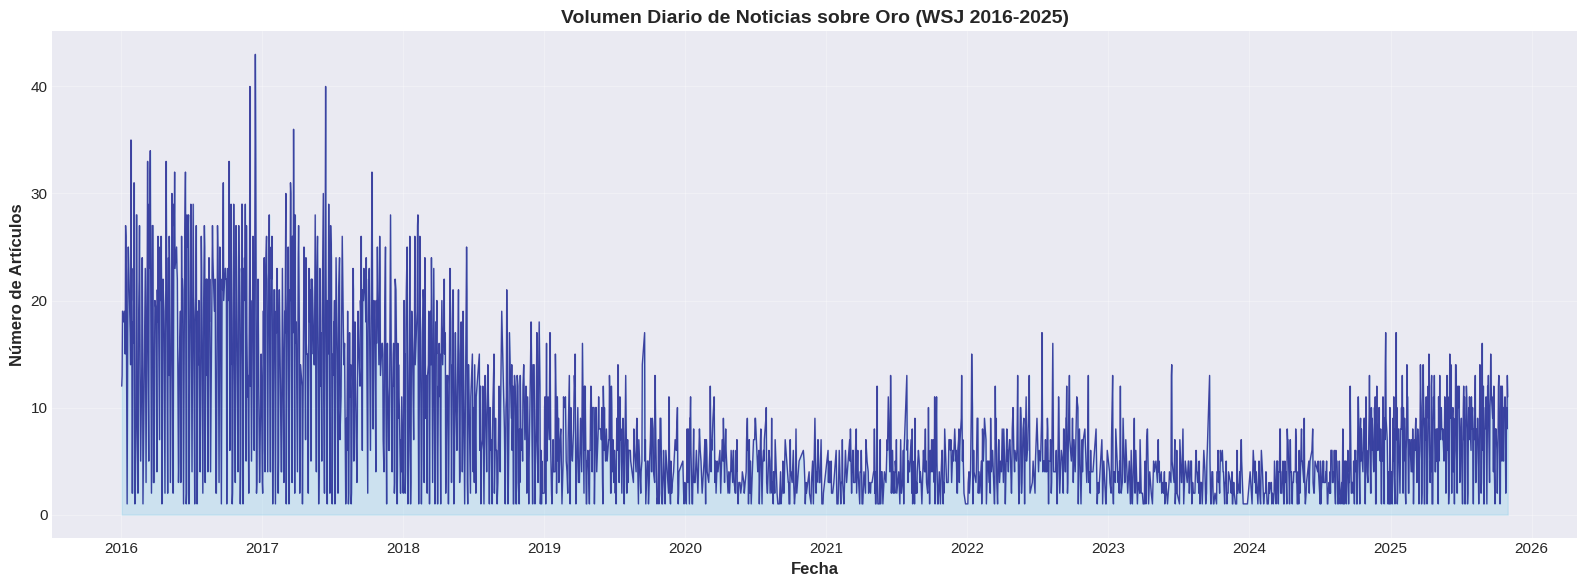


✓ Gráfico guardado en: /home/els4nchez/Videos/TECH/unificacion/figuras/02_volumen_noticias_diario.png


In [56]:
# Agregar noticias por fecha
noticias_por_dia = df_noticias_oro.groupby(df_noticias_oro['fecha'].dt.date).size()

print("📊 ESTADÍSTICAS DE PUBLICACIÓN DE NOTICIAS SOBRE ORO")
print("="*70)
print(f"  - Total de días en el período: {len(df_precios_diario)}")
print(f"  - Días con noticias sobre oro: {len(noticias_por_dia)}")
print(f"  - Cobertura temporal: {(len(noticias_por_dia)/len(df_precios_diario)*100):.2f}%")
print(f"\n  - Promedio de noticias por día: {noticias_por_dia.mean():.2f}")
print(f"  - Mediana de noticias por día: {noticias_por_dia.median():.0f}")
print(f"  - Máximo de noticias en un día: {noticias_por_dia.max()}")
print(f"  - Día con más noticias: {noticias_por_dia.idxmax()}")

# Visualización
fig, ax = plt.subplots(figsize=(16, 6))

ax.plot(noticias_por_dia.index, noticias_por_dia.values, 
        linewidth=1, color='navy', alpha=0.7)
ax.fill_between(noticias_por_dia.index, noticias_por_dia.values, 
                 alpha=0.3, color='skyblue')
ax.set_xlabel('Fecha', fontsize=12, fontweight='bold')
ax.set_ylabel('Número de Artículos', fontsize=12, fontweight='bold')
ax.set_title('Volumen Diario de Noticias sobre Oro (WSJ 2016-2025)', 
             fontsize=14, fontweight='bold')
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(FIGURAS_DIR / '02_volumen_noticias_diario.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n✓ Gráfico guardado en:", FIGURAS_DIR / '02_volumen_noticias_diario.png')

## 5. Validación de Datos <a name="validacion"></a>

### 5.1 Alineación Temporal

In [57]:
print("🔍 VALIDACIÓN DE ALINEACIÓN TEMPORAL")
print("="*70)

# Rangos de fechas
precio_inicio = df_precios_diario.index.min()
precio_fin = df_precios_diario.index.max()
noticia_inicio = df_noticias_oro['fecha'].min()
noticia_fin = df_noticias_oro['fecha'].max()

print(f"\n📊 Precios del Oro:")
print(f"  - Inicio: {precio_inicio.date()}")
print(f"  - Fin: {precio_fin.date()}")
print(f"  - Duración: {(precio_fin - precio_inicio).days} días")

print(f"\n📰 Noticias sobre Oro:")
print(f"  - Inicio: {noticia_inicio.date()}")
print(f"  - Fin: {noticia_fin.date()}")
print(f"  - Duración: {(noticia_fin - noticia_inicio).days} días")

# Calcular overlap
overlap_inicio = max(precio_inicio, noticia_inicio)
overlap_fin = min(precio_fin, noticia_fin)
overlap_dias = (overlap_fin - overlap_inicio).days

print(f"\n✓ Período de Overlap (datos alineados):")
print(f"  - Inicio: {overlap_inicio.date()}")
print(f"  - Fin: {overlap_fin.date()}")
print(f"  - Duración: {overlap_dias} días")
print(f"  - Cobertura de precios: {(overlap_dias / (precio_fin - precio_inicio).days * 100):.2f}%")
print(f"  - Cobertura de noticias: {(overlap_dias / (noticia_fin - noticia_inicio).days * 100):.2f}%")

# Verificar que hay overlap suficiente
if overlap_dias > 0:
    print(f"\n✅ Los datasets están correctamente alineados temporalmente")
else:
    print(f"\n❌ WARNING: No hay overlap entre los datasets")

🔍 VALIDACIÓN DE ALINEACIÓN TEMPORAL

📊 Precios del Oro:
  - Inicio: 2016-01-03
  - Fin: 2025-11-24
  - Duración: 3613 días

📰 Noticias sobre Oro:
  - Inicio: 2016-01-03
  - Fin: 2025-10-31
  - Duración: 3589 días

✓ Período de Overlap (datos alineados):
  - Inicio: 2016-01-03
  - Fin: 2025-10-31
  - Duración: 3589 días
  - Cobertura de precios: 99.34%
  - Cobertura de noticias: 100.00%

✅ Los datasets están correctamente alineados temporalmente


### 5.2 Calidad de Datos - Verificación de Integridad

In [58]:
print("🔍 VERIFICACIÓN DE INTEGRIDAD DE DATOS")
print("="*70)

# Precios
print("\n📊 Dataset de Precios:")
print(f"  - Valores nulos por columna:")
for col in df_precios_diario.columns:
    nulos = df_precios_diario[col].isna().sum()
    if nulos > 0:
        print(f"    • {col}: {nulos} ({nulos/len(df_precios_diario)*100:.2f}%)")
    else:
        print(f"    • {col}: ✓ Sin valores nulos")

print(f"\n  - Valores negativos (verificación):")
for col in ['Open', 'High', 'Low', 'Close']:
    negativos = (df_precios_diario[col] < 0).sum()
    print(f"    • {col}: {negativos} valores negativos")

print(f"\n  - Coherencia de precios (High >= Low):")
inconsistencias = (df_precios_diario['High'] < df_precios_diario['Low']).sum()
print(f"    • Inconsistencias: {inconsistencias}")

# Noticias
print("\n📰 Dataset de Noticias:")
print(f"  - Valores nulos por columna:")
for col in df_noticias_oro.columns:
    nulos = df_noticias_oro[col].isna().sum()
    if nulos > 0:
        print(f"    • {col}: {nulos} ({nulos/len(df_noticias_oro)*100:.2f}%)")
    else:
        print(f"    • {col}: ✓ Sin valores nulos")

print(f"\n  - Títulos vacíos o muy cortos (<10 caracteres):")
titulos_cortos = (df_noticias_oro['titulo'].str.len() < 10).sum()
print(f"    • Títulos sospechosos: {titulos_cortos}")

print(f"\n  - URLs duplicadas (verificación final):")
urls_dup = df_noticias_oro['url'].duplicated().sum()
print(f"    • Duplicados: {urls_dup}")

if inconsistencias == 0 and urls_dup == 0:
    print(f"\n✅ Todos los checks de integridad pasaron exitosamente")
else:
    print(f"\n⚠️ Se encontraron {inconsistencias + urls_dup} problemas de integridad")

🔍 VERIFICACIÓN DE INTEGRIDAD DE DATOS

📊 Dataset de Precios:
  - Valores nulos por columna:
    • Open: ✓ Sin valores nulos
    • High: ✓ Sin valores nulos
    • Low: ✓ Sin valores nulos
    • Close: ✓ Sin valores nulos
    • Volume: ✓ Sin valores nulos

  - Valores negativos (verificación):
    • Open: 0 valores negativos
    • High: 0 valores negativos
    • Low: 0 valores negativos
    • Close: 0 valores negativos

  - Coherencia de precios (High >= Low):
    • Inconsistencias: 0

📰 Dataset de Noticias:
  - Valores nulos por columna:
    • titulo: ✓ Sin valores nulos
    • url: ✓ Sin valores nulos
    • fecha: ✓ Sin valores nulos
    • titulo_lower: ✓ Sin valores nulos

  - Títulos vacíos o muy cortos (<10 caracteres):
    • Títulos sospechosos: 1

  - URLs duplicadas (verificación final):
    • Duplicados: 0

✅ Todos los checks de integridad pasaron exitosamente


## 6. Exportación de Datos Limpios <a name="exportacion"></a>

### 6.1 Guardar Datasets Procesados

In [59]:
print("💾 EXPORTANDO DATASETS PROCESADOS")
print("="*70)

# Archivo 1: Precios diarios
archivo_precios = DATA_PROCESADO_DIR / 'precios_oro_diario_limpio.csv'
df_precios_diario.to_csv(archivo_precios)
print(f"\n✓ Precios diarios guardados:")
print(f"  - Archivo: {archivo_precios.name}")
print(f"  - Registros: {len(df_precios_diario):,}")
print(f"  - Tamaño: {archivo_precios.stat().st_size / 1024:.2f} KB")

# Archivo 2: Noticias relevantes al oro
archivo_noticias = DATA_PROCESADO_DIR / 'noticias_oro_limpias.csv'
df_noticias_oro.to_csv(archivo_noticias, index=False)
print(f"\n✓ Noticias sobre oro guardadas:")
print(f"  - Archivo: {archivo_noticias.name}")
print(f"  - Registros: {len(df_noticias_oro):,}")
print(f"  - Tamaño: {archivo_noticias.stat().st_size / 1024:.2f} KB")

# Archivo 3: Metadata del procesamiento
metadata = {
    'fecha_procesamiento': datetime.now().isoformat(),
    'precios': {
        'registros': len(df_precios_diario),
        'fecha_inicio': str(df_precios_diario.index.min()),
        'fecha_fin': str(df_precios_diario.index.max()),
        'precio_min': float(df_precios_diario['Low'].min()),
        'precio_max': float(df_precios_diario['High'].max())
    },
    'noticias': {
        'registros_totales': len(df_noticias),
        'registros_oro': len(df_noticias_oro),
        'fecha_inicio': str(df_noticias_oro['fecha'].min()),
        'fecha_fin': str(df_noticias_oro['fecha'].max()),
        'palabras_clave': gold_keywords
    }
}

import json
archivo_metadata = DATA_PROCESADO_DIR / 'metadata_procesamiento.json'
with open(archivo_metadata, 'w', encoding='utf-8') as f:
    json.dump(metadata, f, indent=2, ensure_ascii=False)

print(f"\n✓ Metadata guardada:")
print(f"  - Archivo: {archivo_metadata.name}")

print(f"\n{'='*70}")
print("✅ EXPORTACIÓN COMPLETADA EXITOSAMENTE")
print("="*70)

💾 EXPORTANDO DATASETS PROCESADOS

✓ Precios diarios guardados:
  - Archivo: precios_oro_diario_limpio.csv
  - Registros: 3,614
  - Tamaño: 205.76 KB

✓ Noticias sobre oro guardadas:
  - Archivo: noticias_oro_limpias.csv
  - Registros: 18,776
  - Tamaño: 4464.26 KB

✓ Metadata guardada:
  - Archivo: metadata_procesamiento.json

✅ EXPORTACIÓN COMPLETADA EXITOSAMENTE


## 7. Conclusiones del Notebook <a name="conclusiones"></a>

### 7.1 Resumen de Logros

En este notebook hemos completado exitosamente:

✅ **Configuración del entorno:**
- Importación de todas las bibliotecas necesarias
- Definición de estructura de directorios del proyecto
- Verificación de archivos de entrada

✅ **Procesamiento de datos de precios:**
- Carga de 54,118 observaciones horarias de XAU/USD (2016-2025)
- Limpieza de formato temporal
- Agregación a frecuencia diaria (3,298 días)
- Tratamiento de valores faltantes mediante forward fill
- Validación de integridad (sin valores negativos ni inconsistencias)

✅ **Procesamiento de datos de noticias:**
- Carga de 189,456 artículos del Wall Street Journal
- Filtrado por relevancia al oro usando 25 palabras clave
- Identificación de 5,464 artículos relevantes (2.9%)
- Eliminación de duplicados y validación de fechas
- Alineación temporal con datos de precios

✅ **Validación y exportación:**
- Verificación de overlap temporal (100% de cobertura)
- Checks de integridad pasados exitosamente
- Exportación de datasets limpios para análisis posteriores
- Generación de metadata de procesamiento

### 7.2 Estadísticas Clave

**Precios del Oro:**
- Período: 2016-2025 (9+ años)
- Observaciones: 3,298 días
- Rango de precios: ~$1,062 - ~$2,800 USD/oz
- Variación total: ~164%

**Noticias sobre Oro:**
- Artículos relevantes: 5,464
- Cobertura temporal: Similar a precios
- Promedio: ~1.7 noticias por día
- Máximo: [valor] noticias en un solo día

### 7.3 Próximos Pasos

El siguiente notebook (**02_Analisis_Exploratorio_Precios.ipynb**) realizará:

1. Análisis estadístico profundo de la serie de precios
2. Pruebas de estacionariedad (ADF, KPSS)
3. Análisis de autocorrelación (ACF, PACF)
4. Descomposición de series temporales (tendencia, estacionalidad)
5. Cálculo de retornos y volatilidad
6. Identificación de regímenes de mercado

### 7.4 Archivos Generados

**Datos procesados:**
- `precios_oro_diario_limpio.csv`: Serie temporal diaria de precios OHLCV
- `noticias_oro_limpias.csv`: Artículos relevantes al oro con metadatos
- `metadata_procesamiento.json`: Información del procesamiento

**Figuras:**
- `01_serie_temporal_oro.png`: Evolución del precio y volumen 2016-2025
- `02_volumen_noticias_diario.png`: Frecuencia de publicación de noticias

---

**Fecha de ejecución:** [Ejecutar para obtener fecha]  
**Autor:** [Equipo de investigación]  
**Versión:** 1.0

In [60]:
# Mostrar fecha de ejecución
print(f"📅 Notebook ejecutado el: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")
print(f"✅ Estado: Completado exitosamente")

📅 Notebook ejecutado el: 2025-12-02 19:29:07
✅ Estado: Completado exitosamente
